##### 1. import dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install rarfile

import os
import rarfile
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Mounted at /content/drive


##### 2. Load Dataset

In [2]:
dataset_path = '/content/drive/MyDrive/MachineLearning/UAP/Klasifikasi Transportasi Udara.rar'

with rarfile.RarFile(dataset_path, 'r') as rar_ref:
    rar_ref.extractall('/content/dataset')

dataset_folder = '/content/dataset/Klasifikasi Transportasi Udara'

##### 3. EDA - Exploratory Data Analysis

In [3]:
labels = os.listdir(dataset_folder)
print("Classes/Labels:", labels)

Classes/Labels: ['pesawat komersial', 'pesawat jet militer', 'helikopter', 'pesawat kargo']


###### a. jumlah gambar per kelas

In [4]:
label_counts = {label: len(os.listdir(os.path.join(dataset_folder, label))) for label in labels}
print("Image Distribution per Class:", label_counts)

Image Distribution per Class: {'pesawat komersial': 2905, 'pesawat jet militer': 2900, 'helikopter': 2387, 'pesawat kargo': 1891}


###### b. Visualisasi distribusi data

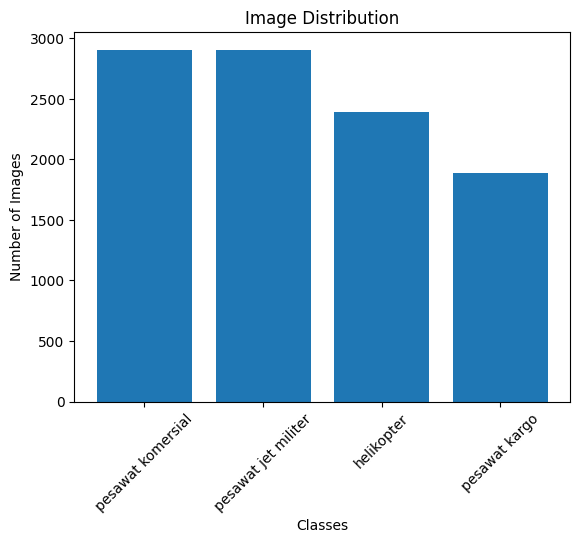

In [5]:
plt.bar(label_counts.keys(), label_counts.values())
plt.title("Image Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

###### c. Menampilkan gambar dari setiap label

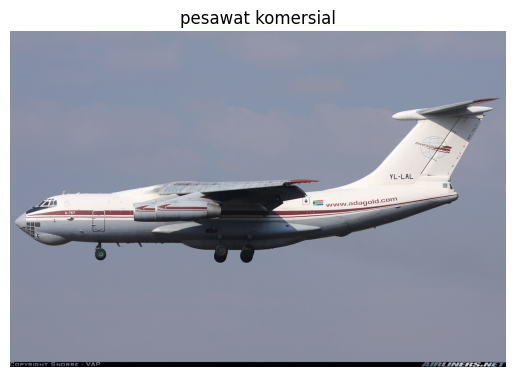

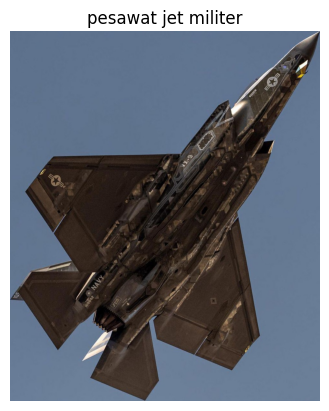

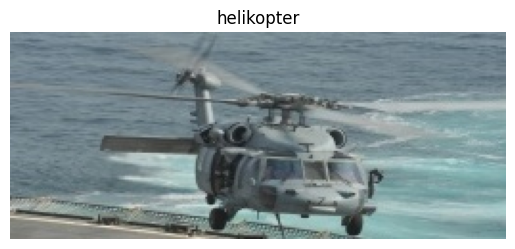

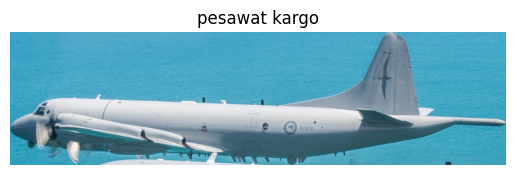

In [6]:
for label in labels:
    sample_image_path = os.path.join(dataset_folder, label, os.listdir(os.path.join(dataset_folder, label))[0])
    sample_image = plt.imread(sample_image_path)
    plt.imshow(sample_image)
    plt.title(label)
    plt.axis('off')
    plt.show()

##### 4. Preprocessing

In [7]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    dataset_folder,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_folder,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 8067 images belonging to 4 classes.
Found 2016 images belonging to 4 classes.


##### 5. Model VGG

In [8]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in vgg_base.layers:
    layer.trainable = False

x = Flatten()(vgg_base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(labels), activation='softmax')(x)

model = Model(inputs=vgg_base.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 1,049,220 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

##### 6. Training Model

In [9]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


253/253 ━━━━━━━━━━━━━━━━━━━━ 111s 395ms/step - accuracy: 0.7053 - loss: 0.7282 - val_accuracy: 0.8805 - val_loss: 0.2973
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 97s 377ms/step - accuracy: 0.8886 - loss: 0.2979 - val_accuracy: 0.9033 - val_loss: 0.2550
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 96s 374ms/step - accuracy: 0.9195 - loss: 0.2197 - val_accuracy: 0.9053 - val_loss: 0.2391
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 143s 364ms/step - accuracy: 0.9332 - loss: 0.1898 - val_accuracy: 0.9182 - val_loss: 0.2208
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 99s 383ms/step - accuracy: 0.9440 - loss: 0.1639 - val_accuracy: 0.9211 - val_loss: 0.2022
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 96s 373ms/step - accuracy: 0.9500 - loss: 0.1464 - val_accuracy: 0.9182 - val_loss: 0.2093
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 99s 380ms/step - accuracy: 0.9557 - loss: 0.1298 - val_accuracy: 0.9286 - val_loss: 0.1838
Epoch 8/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 96s 371ms/step - accuracy: 0.9648 - loss: 0.1106 - v

###### a. menyimpan model ke file .h5

In [10]:
model_save_path = '/content/drive/MyDrive/MachineLearning/UAP/model_klasifikasi_transportasi_vgg.h5'
model.save(model_save_path)
print(f"Model telah disimpan di: {model_save_path}")

Model telah disimpan di: /content/drive/MyDrive/MachineLearning/UAP/model_klasifikasi_transportasi_vgg.h5


##### 7. Evaluasi

###### a. Akurasi dan Loss

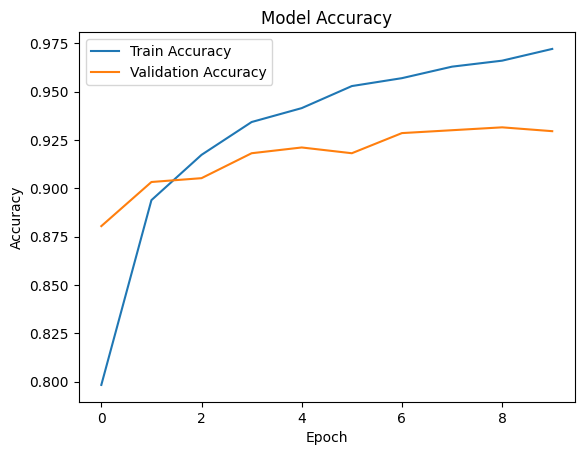

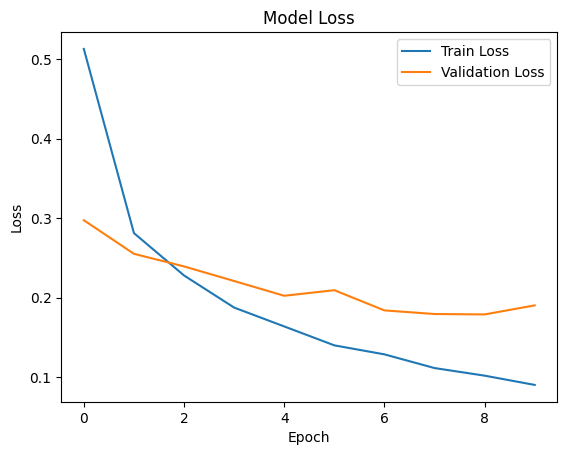

In [11]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

###### b. Classification Report

In [12]:
val_generator.reset()
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis=1)
print(classification_report(y_true, y_pred, target_names=labels))

63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 394ms/step
                     precision    recall  f1-score   support

  pesawat komersial       0.23      0.23      0.23       477
pesawat jet militer       0.30      0.27      0.28       580
         helikopter       0.18      0.20      0.19       378
      pesawat kargo       0.31      0.31      0.31       581

           accuracy                           0.26      2016
          macro avg       0.25      0.25      0.25      2016
       weighted avg       0.26      0.26      0.26      2016



###### c. Prediksi pada 4 Gambar Acak

In [17]:
test_images, test_labels = next(val_generator)
random_indices = random.sample(range(len(test_images)), 4)
selected_images = [test_images[i] for i in random_indices]
selected_labels = [test_labels[i] for i in random_indices]

###### d. Visualisasi Prediksi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


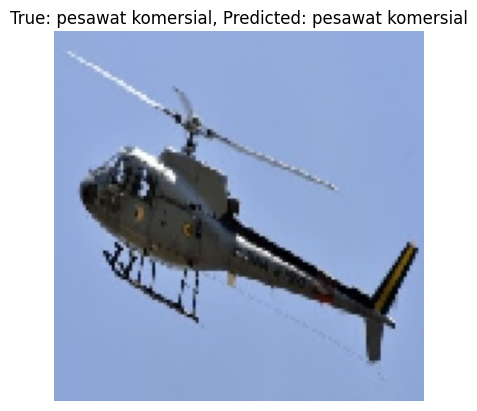

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


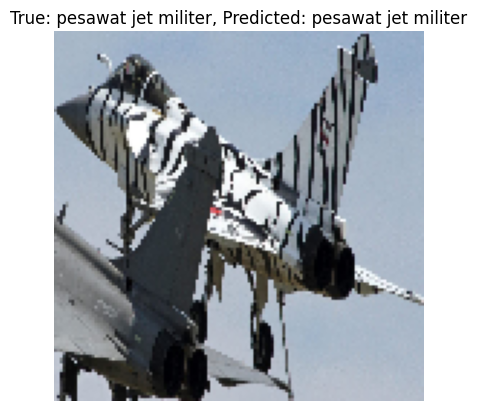

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


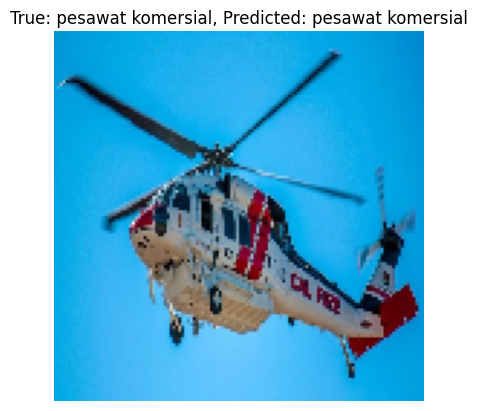

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


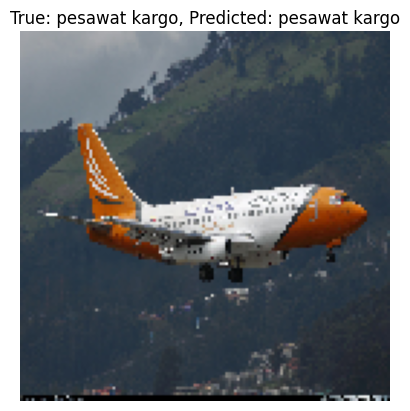

In [18]:
for i, image in enumerate(selected_images):
    prediction = model.predict(image[np.newaxis, ...])
    predicted_label = labels[np.argmax(prediction)]
    true_label = labels[np.argmax(selected_labels[i])]

    plt.imshow(image)
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()